# coNNect: Friend Recommendation with GNNs
# Our GNN Solution

*Created by Horváth Szilárd (MZ7VX5) and Szarvas Dániel (A85UKT)*

This notebook consists of the training and inference pipeline for our GNN solution implemented for the friend recommendation problem.

In [1]:
import torch

print(torch.__version__)

2.5.1+cu121


In [2]:
!pip install -q torch_geometric
!pip install wandb -q
!pip install pytorch-lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 35.2 MB/s eta 0:00:00


### Prepare dataset

Choose which dataset to load. The average loading times for the datasets:
- `ego-facebook` (Facebook): 17 seconds
- `ego-gplus` (Google+): 43 minutes


In [3]:
from torch_geometric.datasets import SNAPDataset

# Select from "ego-gplus" and "ego-facebook"
dataset_name = "ego-facebook"
dataset = SNAPDataset(root='data', name=dataset_name)

Processing...
100%|██████████| 10/10 [00:01<00:00,  9.26it/s]
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([EgoData])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [4]:
print(f"Size of dataset (number of graphs/egonets): {dataset.len()}\n")

dataset[0], dataset[1], dataset[2], dataset[3]

Size of dataset (number of graphs/egonets): 10



(EgoData(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325]),
 EgoData(x=[1045, 1406], edge_index=[2, 55510], circle=[501], circle_batch=[501]),
 EgoData(x=[792, 1406], edge_index=[2, 29618], circle=[777], circle_batch=[777]),
 EgoData(x=[755, 1406], edge_index=[2, 61484], circle=[1065], circle_batch=[1065]))

In [5]:
import torch
from torch_geometric.data import Data

edge_index_offset = 0
combined_edge_index = None
combined_x = None

for i in range(len(dataset)):
  data = dataset[i]
  # Shift node indices in edge_index
  shifted_edge_index = data.edge_index + edge_index_offset

  if combined_edge_index is None:
    combined_edge_index = shifted_edge_index
  else:
    combined_edge_index = torch.cat([combined_edge_index, shifted_edge_index], dim=1)

  if combined_x is None:
    combined_x = data.x
  else:
    combined_x = torch.cat([combined_x, data.x], dim=0)

  edge_index_offset += data.num_nodes

facebook_combined_geo_data = Data(x=combined_x, edge_index=combined_edge_index)

In [6]:
val_size = 0.1
test_size = 0.2
epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Create train-test split with random link splitting (for the first egonet)

In [7]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
    is_undirected=True,
    num_val=val_size,
    num_test=test_size,
    split_labels=True,
    add_negative_train_samples=True,
)

geo_train, geo_val, geo_test = transform(facebook_combined_geo_data)
geo_train.x = geo_train.x.to(device)
geo_val.x = geo_val.x.to(device)
geo_test.x = geo_test.x.to(device)

### Create negative samples for validation

Negative samples are necessary in case of a link prediction GNN for validation and test sets.

In [8]:
from torch_geometric.utils import negative_sampling

# Manually generate negative samples for validation and test sets
geo_val.neg_edge_index = negative_sampling(
    edge_index=geo_val.edge_index,
    num_nodes=geo_val.num_nodes,
    num_neg_samples=geo_val.edge_index.size(1)
)

geo_test.neg_edge_index = negative_sampling(
    edge_index=geo_test.edge_index,
    num_nodes=geo_test.num_nodes,
    num_neg_samples=geo_test.edge_index.size(1)
)

### Define `coNNect` GNN model

Create a highly configurable graph neural network (GNN) for the friend prediction tasks. It must be prepared for Wandb's sweeps for hyperparameter optimization.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import pytorch_lightning as pl
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.loader import DataLoader
from pytorch_lightning.loggers import WandbLogger
import wandb


class CoNNectLinkPredictor(pl.LightningModule):
    def __init__(self, in_channels, hidden_channels, num_layers, conv_type, train_data, val_data, test_data, dropout=0.3):
        super(CoNNectLinkPredictor, self).__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        self.save_hyperparameters()
        self.conv = nn.ModuleList()
        conv_class = getattr(gnn, conv_type)

        self.conv.append(conv_class(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.conv.append(conv_class(hidden_channels, hidden_channels))

        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.conv:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return x

    def decode(self, z, pos_edge_index, neg_edge_index):
        # Positive edge score
        pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
        neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
        return pos_score, neg_score

    def training_step(self, batch, batch_idx):
        # Generate embeddings
        z = self(self.train_data.x, self.train_data.edge_index)

        # Dynamic negative sampling
        train_neg_edge_index = negative_sampling(
            edge_index=self.train_data.edge_index,
            num_nodes=self.train_data.num_nodes,
            num_neg_samples=self.train_data.edge_index.size(1)
        )

        pos_score, neg_score = self.decode(z, self.train_data.edge_index, train_neg_edge_index)

        pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones_like(pos_score))
        neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros_like(neg_score))
        loss = pos_loss + neg_loss

        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        z = self(self.val_data.x, self.val_data.edge_index)

        pos_score, neg_score = self.decode(z, self.val_data.edge_index, self.val_data.neg_edge_index)

        y_true = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))])
        y_score = torch.cat([pos_score, neg_score])

        auc = roc_auc_score(y_true.cpu(), y_score.cpu())
        ap = average_precision_score(y_true.cpu(), y_score.cpu())

        self.log("val_auc", auc, on_epoch=True, prog_bar=True)
        self.log("val_ap", ap, on_epoch=True, prog_bar=True)
        return {"val_auc": auc, "val_ap": ap}

    def test_step(self, batch, batch_idx):
        z = self(self.test_data.x, self.test_data.edge_index)
        pos_score, neg_score = self.decode(z, self.test_data.edge_index, self.test_data.neg_edge_index)

        y_true = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))])
        y_score = torch.cat([pos_score, neg_score])

        auc = roc_auc_score(y_true.cpu(), y_score.cpu())
        ap = average_precision_score(y_true.cpu(), y_score.cpu())

        self.log("test_auc", auc, on_epoch=True)
        self.log("test_ap", ap, on_epoch=True)
        return {"test_auc": auc, "test_ap": ap}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

    def train_dataloader(self):
        self.train_data = self.train_data.to(device)
        return DataLoader([self.train_data], batch_size=1)

    def val_dataloader(self):
        self.val_data = self.val_data.to(device)
        return DataLoader([self.val_data], batch_size=1)

    def test_dataloader(self):
        self.test_data = self.test_data.to(device)
        return DataLoader([self.test_data], batch_size=1)


### Train `coNNect` model (with Wandb sweeps)

Created a random sweep with changeable number of hidden channels (`hidden_channels`,) convolution type (`conv_type`), number of layers (`num_layers`) and dropout rate (`dropout`).

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_auc',
        'goal': 'maximize'
    },
    'parameters': {
        'hidden_channels': {
            'values': [32, 64]
        },
        'conv_type': {
            'values': ["GCNConv", "SAGEConv"]
        },
        'num_layers': {
            'values': [2, 4, 8]
        },
        'dropout': {
            'values': [0.1, 0.3]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="gnn_coNNect")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 046n0srv
Sweep URL: https://wandb.ai/horvath-szilard-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg/gnn_coNNect/sweeps/046n0srv


Define training function to be run by the Wandb sweeps.

In [10]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb_logger = WandbLogger(project='gnn_coNNect', log_model="all")

        # Instantiate GNN
        model = CoNNectLinkPredictor(
            in_channels=geo_train.num_features,
            hidden_channels=config.hidden_channels,
            num_layers=config.num_layers,
            conv_type=config.conv_type,
            dropout=config.dropout,
            train_data=geo_train,
            val_data=geo_val,
            test_data=geo_test,
        )
        model = model.to(device)

        # Register checkpointing and early stopping callbacks
        checkpoint_callback = pl.callbacks.ModelCheckpoint()
        early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_auc", patience=3, verbose=False, mode="max")

        trainer = pl.Trainer(max_epochs=epochs,
                    callbacks=[checkpoint_callback, early_stop_callback],
                    logger = wandb_logger,
                    log_every_n_steps=10,
                    accelerator=device,
                    devices=1,
                    )

        # Train the model
        trainer.fit(model)
        wandb.finish()

In [ ]:
wandb.agent(sweep_id, train_model, count=8)

wandb: Agent Starting Run: 063fypgc with config:
wandb: 	conv_type: SAGEConv
wandb: 	dropout: 0.1
wandb: 	hidden_channels: 32
wandb: 	num_layers: 2
wandb: Currently logged in as: horvath-szilard (horvath-szilard-budapesti-m-szaki-s-gazdas-gtudom-nyi-eg). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 92.1 K | train
--------------------------------------------
92.1 K    Trainable params
0         Non-trainable params
92.1 K    Total params
0.368     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4167. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
train_loss_epoch,█▇▅▄▃▃▂▂▂▂▁▁▁▁
train_loss_step,▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
val_ap,▁▂▅▆▇█████████
val_auc,▁▃▆▇▇█████████
epoch,13
train_loss_epoch,1.02094
train_loss_step,1.05293
trainer/global_step,13
val_ap,0.90298


wandb: Agent Starting Run: gmmhsr6p with config:
wandb: 	conv_type: SAGEConv
wandb: 	dropout: 0.1
wandb: 	hidden_channels: 32
wandb: 	num_layers: 4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 96.3 K | train
--------------------------------------------
96.3 K    Trainable params
0         Non-trainable params
96.3 K    Total params
0.385     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
train_loss_epoch,█▇▆▅▃▄▃▁▁
trainer/global_step,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
val_ap,▁▂▂▃▅█▇▇█
val_auc,▂▁▂▃▅████
epoch,8
train_loss_epoch,1.19567
trainer/global_step,8
val_ap,0.83024
val_auc,0.8071


wandb: Agent Starting Run: q8ewy062 with config:
wandb: 	conv_type: GCNConv
wandb: 	dropout: 0.1
wandb: 	hidden_channels: 64
wandb: 	num_layers: 8


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 119 K  | train
--------------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.477     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▃▃▅▅▆▆██
train_loss_epoch,▁█▁▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_ap,▅█▂▂▁
val_auc,▄█▂▂▁
epoch,4
train_loss_epoch,1.38382
trainer/global_step,4
val_ap,0.76847
val_auc,0.79013


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 40y6kdsd with config:
wandb: 	conv_type: SAGEConv
wandb: 	dropout: 0.1
wandb: 	hidden_channels: 32
wandb: 	num_layers: 8


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 104 K  | train
--------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.418     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▂▂▃▃▅▅▆▆▇▇██
train_loss_epoch,█▆▅▅▄▁▄
trainer/global_step,▁▁▂▂▃▃▅▅▆▆▇▇██
val_ap,▁▆▆█▃▁▆
val_auc,▁███▇▆▄
epoch,6
train_loss_epoch,1.37898
trainer/global_step,6
val_ap,0.77367
val_auc,0.72266


wandb: Agent Starting Run: xjdm0rbi with config:
wandb: 	conv_type: SAGEConv
wandb: 	dropout: 0.1
wandb: 	hidden_channels: 64
wandb: 	num_layers: 8


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 237 K  | train
--------------------------------------------
237 K     Trainable params
0         Non-trainable params
237 K     Total params
0.951     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
train_loss_epoch,▁▁▁▁▁▁▁█▁
trainer/global_step,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
val_ap,▂▁▆▆▇██▇▆
val_auc,▁▁▆▆▇██▇▆
epoch,8
train_loss_epoch,1.23349
trainer/global_step,8
val_ap,0.70218
val_auc,0.62654


wandb: Agent Starting Run: 90upro1k with config:
wandb: 	conv_type: GCNConv
wandb: 	dropout: 0.3
wandb: 	hidden_channels: 32
wandb: 	num_layers: 2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 46.1 K | train
--------------------------------------------
46.1 K    Trainable params
0         Non-trainable params
46.1 K    Total params
0.184     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▇▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_loss_step,█▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_ap,▁▄▅▅▆▆▇▇▇▇▇█████████
val_auc,▁▃▄▄▅▆▆▇▇▇▇▇████████
epoch,19
train_loss_epoch,0.9967
train_loss_step,0.9967
trainer/global_step,19
val_ap,0.95631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xj9lphdq with config:
wandb: 	conv_type: GCNConv
wandb: 	dropout: 0.3
wandb: 	hidden_channels: 32
wandb: 	num_layers: 4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 48.2 K | train
--------------------------------------------
48.2 K    Trainable params
0         Non-trainable params
48.2 K    Total params
0.193     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇▇██
train_loss_epoch,█▇▅▄▃▂▂▂▂▁▁
train_loss_step,▁
trainer/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇▇██
val_ap,▁▄▄▅▅▆▇████
val_auc,▁▃▂▄▃▅▇████
epoch,10
train_loss_epoch,1.11259
train_loss_step,1.12318
trainer/global_step,10
val_ap,0.89731


wandb: Agent Starting Run: ktl9ib6q with config:
wandb: 	conv_type: GCNConv
wandb: 	dropout: 0.3
wandb: 	hidden_channels: 32
wandb: 	num_layers: 8


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 52.4 K | train
--------------------------------------------
52.4 K    Trainable params
0         Non-trainable params
52.4 K    Total params
0.210     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▃▃▅▅▆▆██
train_loss_epoch,█▅▄▁▂
trainer/global_step,▁▁▃▃▅▅▆▆██
val_ap,▁▄█▆▅
val_auc,▆██▂▁
epoch,4
train_loss_epoch,1.3442
trainer/global_step,4
val_ap,0.82525
val_auc,0.80003


### Test the best run

In [11]:
best_parameters = {
    "conv_type": "GCNConv",
    "dropout": 0.3,
    "hidden_channels": 32,
    "num_layers": 2
}

wandb.init(project="gnn_coNNect", config=best_parameters)
wandb_logger = WandbLogger(project='gnn_coNNect', log_model="all")
config = wandb.config

# Instantiate GNN
model = CoNNectLinkPredictor(
    in_channels=geo_train.num_features,
    hidden_channels=config.hidden_channels,
    num_layers=config.num_layers,
    conv_type=config.conv_type,
    dropout=config.dropout,
    train_data=geo_train,
    val_data=geo_val,
    test_data=geo_test,
)
model = model.to(device)

# Register checkpointing and early stopping callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint()
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_auc", patience=7, verbose=False, mode="max")

trainer = pl.Trainer(max_epochs=epochs,
            callbacks=[checkpoint_callback, early_stop_callback],
            logger = wandb_logger,
            log_every_n_steps=10,
            accelerator=device,
            devices=1,
            )

# Train the model
trainer.fit(model)

# Test the model
trainer.test(model, model.test_dataloader())

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | conv | ModuleList | 46.1 K | train
--------------------------------------------
46.1 K    Trainable params
0         Non-trainable params
46.1 K    Total params
0.184     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4167. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_ap          │    0.9546979069709778     │
│         test_auc          │    0.9526888728141785     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_ap,▁
test_auc,▁
train_loss_epoch,█▇▇▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_loss_step,█▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_ap,▁▂▅▅▆▆▆▆▇▇▇▇████████
val_auc,▁▂▄▅▅▅▅▆▇▇▇▇▇███████
epoch,20
test_ap,0.9547
test_auc,0.95269


## Evaluate `coNNect` model

### Plot confusion matrix of model

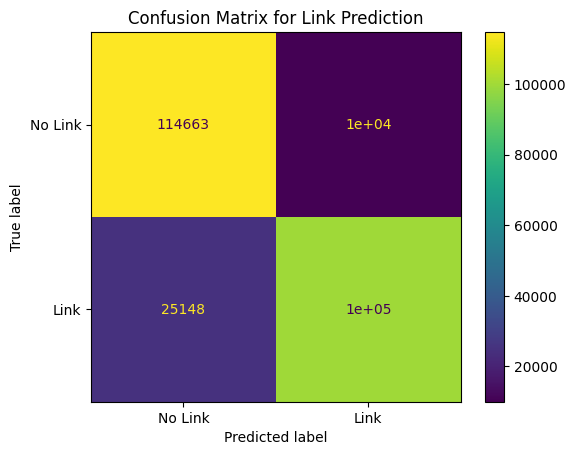

In [12]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Encode node features and predict link scores
z = model(geo_val.x.to(model.device), geo_val.edge_index.to(model.device))

pos_edge_index = geo_val.edge_index.to(model.device)
pos_scores = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)

neg_edge_index = geo_val.neg_edge_index.to(model.device)
neg_scores = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

all_scores = torch.cat([pos_scores, neg_scores]).detach().numpy()
all_labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).detach().numpy()

threshold = 0.5
predicted_labels = (all_scores >= threshold).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Link", "Link"])
disp.plot()
plt.title("Confusion Matrix for Link Prediction")
plt.show()

### Plot ROC Curve of the model

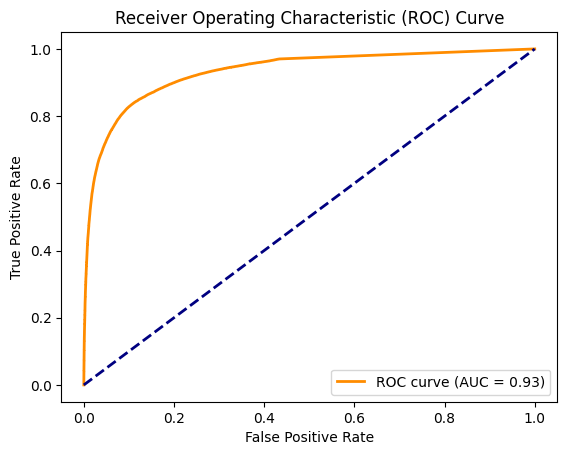

In [13]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Encode node features and predict link scores
z = model(geo_val.x.to(model.device), geo_val.edge_index.to(model.device))

pos_edge_index = geo_val.edge_index.to(model.device)
pos_scores = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)

neg_edge_index = geo_val.neg_edge_index.to(model.device)
neg_scores = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

all_scores = torch.cat([pos_scores, neg_scores]).detach().numpy()
all_labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).detach().numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Gradio interface for user interaction

In [14]:
!pip install gradio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 15.3 MB/s eta 0:00:00


In [ ]:
import gradio

def predict_links(node_index, z, edge_index, top_k=3):
    # Calculate link scores for all possible links
    node_index = int(node_index)
    node_embedding = z[node_index]
    scores = (node_embedding * z).sum(dim=1)

    # Exclude existing links and the node itself
    existing_neighbors = edge_index[1][edge_index[0] == node_index]
    scores[existing_neighbors] = -float('inf')
    scores[node_index] = -float('inf')

    # Get top_k highest scoring nodes
    top_k_indices = torch.topk(scores, top_k).indices

    return top_k_indices.tolist()

def predict(node_id):
    node_id = int(node_id)

    # Get node embeddings for validation data
    model.eval()
    z = model(geo_val.x.to(model.device), geo_val.edge_index.to(model.device))

    # Predict links
    predicted_links = predict_links(node_id, z, geo_val.edge_index)

    return predicted_links[0], predicted_links[1], predicted_links[2]


gradio.Interface(
    fn=predict,
    inputs=["text"],
    outputs=["text", "text", "text"],
    title="GNN Friend Recommendation",
    description="Type in a user ID and the GNN will recommend the 3 most likely new friends for the user.",
).launch(show_error=True,share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4429631f4f9a9a5e50.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
